# Lab Six

## Main Assignment

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
from kneed import KneeLocator
from sklearn.cluster import KMeans, AgglomerativeClustering

### Correct File

In [76]:
with open('data/titanic.csv') as input_file:
    with open('data/data_titanic.csv', 'w') as output_file:
        lines = []
        statuses = []
        for index, line in enumerate(input_file):
            if index == 0:
                lines.append(line.replace(',', ';'))
                continue
            parts = line.split('"')
            parts[0] = parts[0].replace(',', ';')
            parts[2] = parts[2].replace(',', ';')
            statuses.append(parts[1].split(',')[1].split('.')[0].lstrip())
            lines.append(''.join(parts))
        statuses = list(set(statuses))
        output_file.writelines(lines)

### Status-Gender Pairs

In [77]:
status_gender_pairs = {
    'Rev': 'male',
    'Miss': 'female',
    'Ms': 'male',
    'Dr': 'male',
    'Mlle': 'female',
    'Col': 'male',
    'the Countess': 'female',
    'Jonkheer': 'male',
    'Don': 'male',
    'Capt': 'male',
    'Master': 'male',
    'Mme': 'female',
    'Mrs': 'female',
    'Mr': 'male',
    'Lady': 'female',
    'Sir': 'male',
    'Major': 'male'
}

### Load Dataframe

In [78]:
df = pd.read_csv('data/data_titanic.csv', delimiter=';', decimal='.')

### Drop unnecessary columns

In [79]:
df = df.drop(['PassengerId'], axis=1)

### Take a look on what data is missing

/usr/local/lib/python3.10/dist-packages/missingno/missingno.py:61: UserWarning:

Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.



<AxesSubplot: >

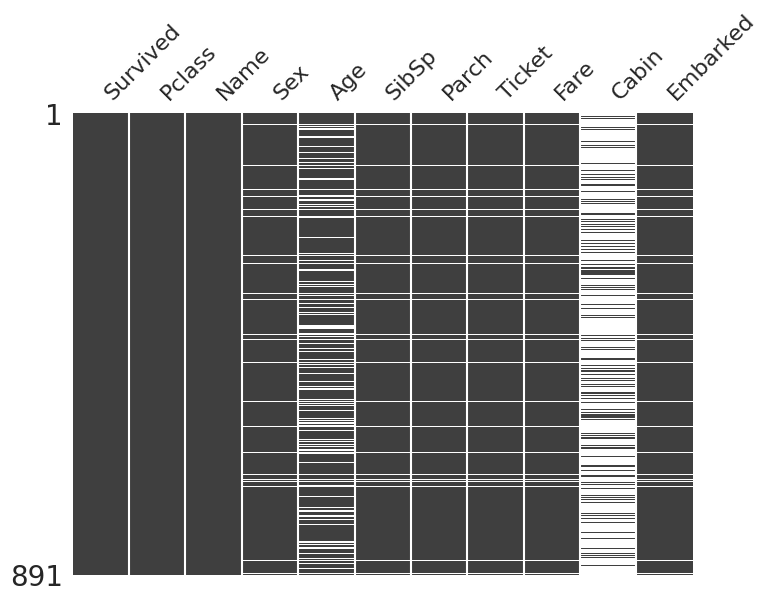

In [80]:
percent_1 = df.isnull().sum() / df.isnull().count() * 100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([percent_2], axis=1, keys=['%'])
plot_rows = 1
plot_cols = 1
fig, axis = plt.subplots(plot_rows, plot_cols, figsize=(8, 6))
msno.matrix(df, ax=axis)

### Empty values by percentage in column

<BarContainer object of 11 artists>

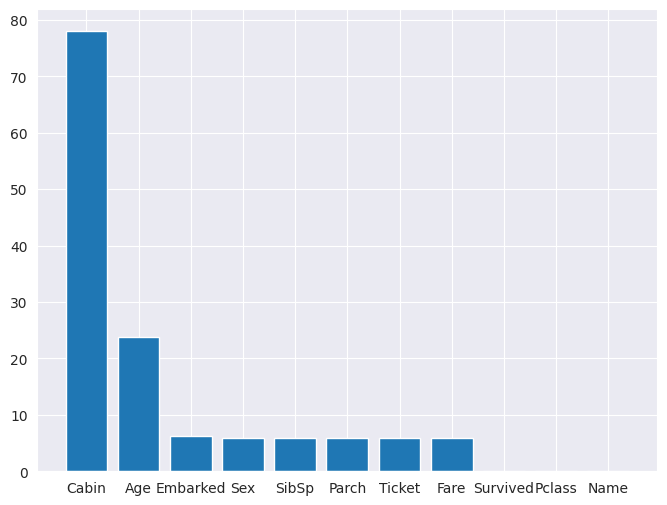

In [81]:
fig, axis = plt.subplots(plot_rows, plot_cols, figsize=(8, 6))
axis.bar(missing_data.index, missing_data.iloc[:, 0])

### Drop "Cabin" due to large number of missing data

In [82]:
df = df.drop(['Cabin'], axis=1)

### Fill Nan "Age"-values with mean

In [83]:
df_sex_mean_age = pd.pivot_table(df, index='Sex', values='Age', aggfunc='mean')
mean_age_female, mean_age_male = df_sex_mean_age.iloc[0, 0], df_sex_mean_age.iloc[1, 0]
df_sex_mean_age

,Age
Sex,
female,28.445833
male,30.863713


### Fill gender

In [84]:
df['Sex'] = df.apply(lambda x: status_gender_pairs[x['Name'].split(',')[1].split('.')[0].lstrip()], axis=1)
df['Gender'] = df.apply(lambda x: x['Sex'] == 'male', axis=1)

def mean_age_functor(row):
    if str(row['Age']) != 'nan':
        return row['Age']
    if row['Sex'] == 'male':
        return mean_age_male
    return mean_age_female


df['Age'] = df.apply(mean_age_functor, axis=1)

### Fill "Embarked" with the most frequent value

([<matplotlib.patches.Wedge at 0x7f6b30da4760>,
 [Text(-0.7389062157855284, 0.8148727534244291, 'S'),
  Text(0.5271737867829742, -0.9654469423686107, 'C'),
  Text(1.069316711618934, -0.2579956787476679, 'Q')],
 [Text(-0.4030397540648336, 0.4444760473224158, '73.4%'),
  Text(0.28754933824525863, -0.5266074231101512, '19.0%'),
  Text(0.5832636608830548, -0.1407249156805461, '7.5%')])

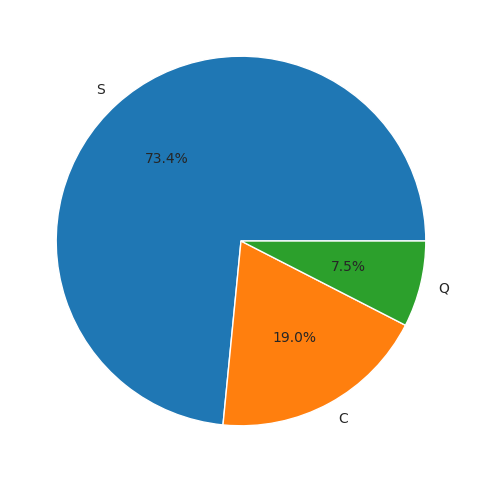

In [85]:
fig, axis = plt.subplots(figsize=(8, 6))
embarked_counts = df['Embarked'].value_counts()
axis.pie(embarked_counts, labels=embarked_counts.index, autopct='%1.1f%%')

### Fill empty embarked with "S"

In [86]:
df['Embarked'].fillna('S', inplace=True)
df['EmbarkedValue'] = df.apply(lambda x: ['S', 'Q', 'C'].index(x['Embarked']), axis=1)

### Fill "Fare" with mean

In [87]:
df['Fare'].fillna(value=df['Fare'].mean(), inplace=True)
df['SibSp'].fillna(value=0, inplace=True)
df['Parch'].fillna(value=0, inplace=True)
df['Relatives'] = df['SibSp'] + df['Parch']
df = df.drop(['Parch', 'SibSp'], axis=1)

### Since the Ticket attribute has 681 unique tickets, it is fair to drop that column

In [88]:
df['Ticket'].describe()

count      838
unique     647
top       1601
freq         7
Name: Ticket, dtype: object

In [89]:
df = df.drop(['Ticket'], axis=1)

### Change column types

In [90]:
for row in df.columns:
    if df[row].dtype == bool:
        df[row] = df[row].astype(int)

### Plot correlation matrix

<AxesSubplot: >

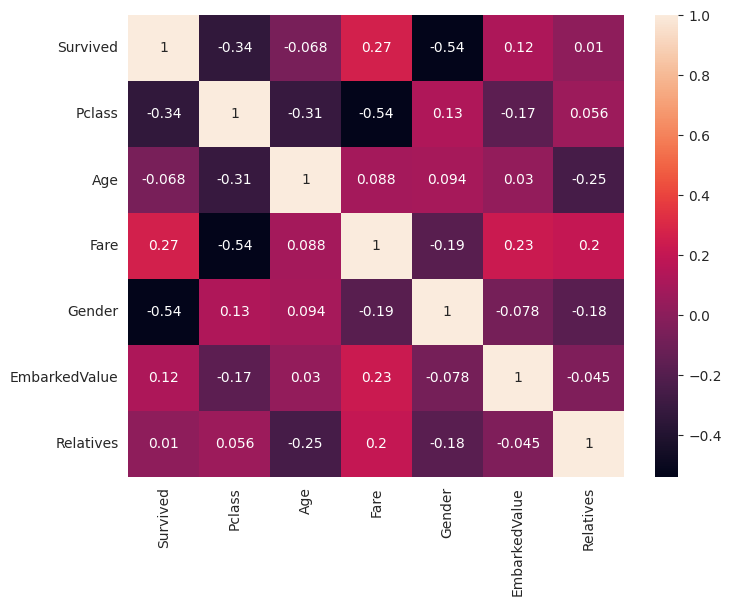

In [91]:
fig, axis = plt.subplots(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), ax=axis, annot=True)

### Plot all correlations

/tmp/ipykernel_66134/2677134439.py:2: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared.



array([[<AxesSubplot: xlabel='Survived', ylabel='Survived'>,
        <AxesSubplot: xlabel='Pclass', ylabel='Survived'>,
        <AxesSubplot: xlabel='Age', ylabel='Survived'>,
        <AxesSubplot: xlabel='Fare', ylabel='Survived'>,
        <AxesSubplot: xlabel='Gender', ylabel='Survived'>,
        <AxesSubplot: xlabel='EmbarkedValue', ylabel='Survived'>,
        <AxesSubplot: xlabel='Relatives', ylabel='Survived'>],
       [<AxesSubplot: xlabel='Survived', ylabel='Pclass'>,
        <AxesSubplot: xlabel='Pclass', ylabel='Pclass'>,
        <AxesSubplot: xlabel='Age', ylabel='Pclass'>,
        <AxesSubplot: xlabel='Fare', ylabel='Pclass'>,
        <AxesSubplot: xlabel='Gender', ylabel='Pclass'>,
        <AxesSubplot: xlabel='EmbarkedValue', ylabel='Pclass'>,
        <AxesSubplot: xlabel='Relatives', ylabel='Pclass'>],
       [<AxesSubplot: xlabel='Survived', ylabel='Age'>,
        <AxesSubplot: xlabel='Pclass', ylabel='Age'>,
        <AxesSubplot: xlabel='Age', ylabel='Age'>,
        <Ax

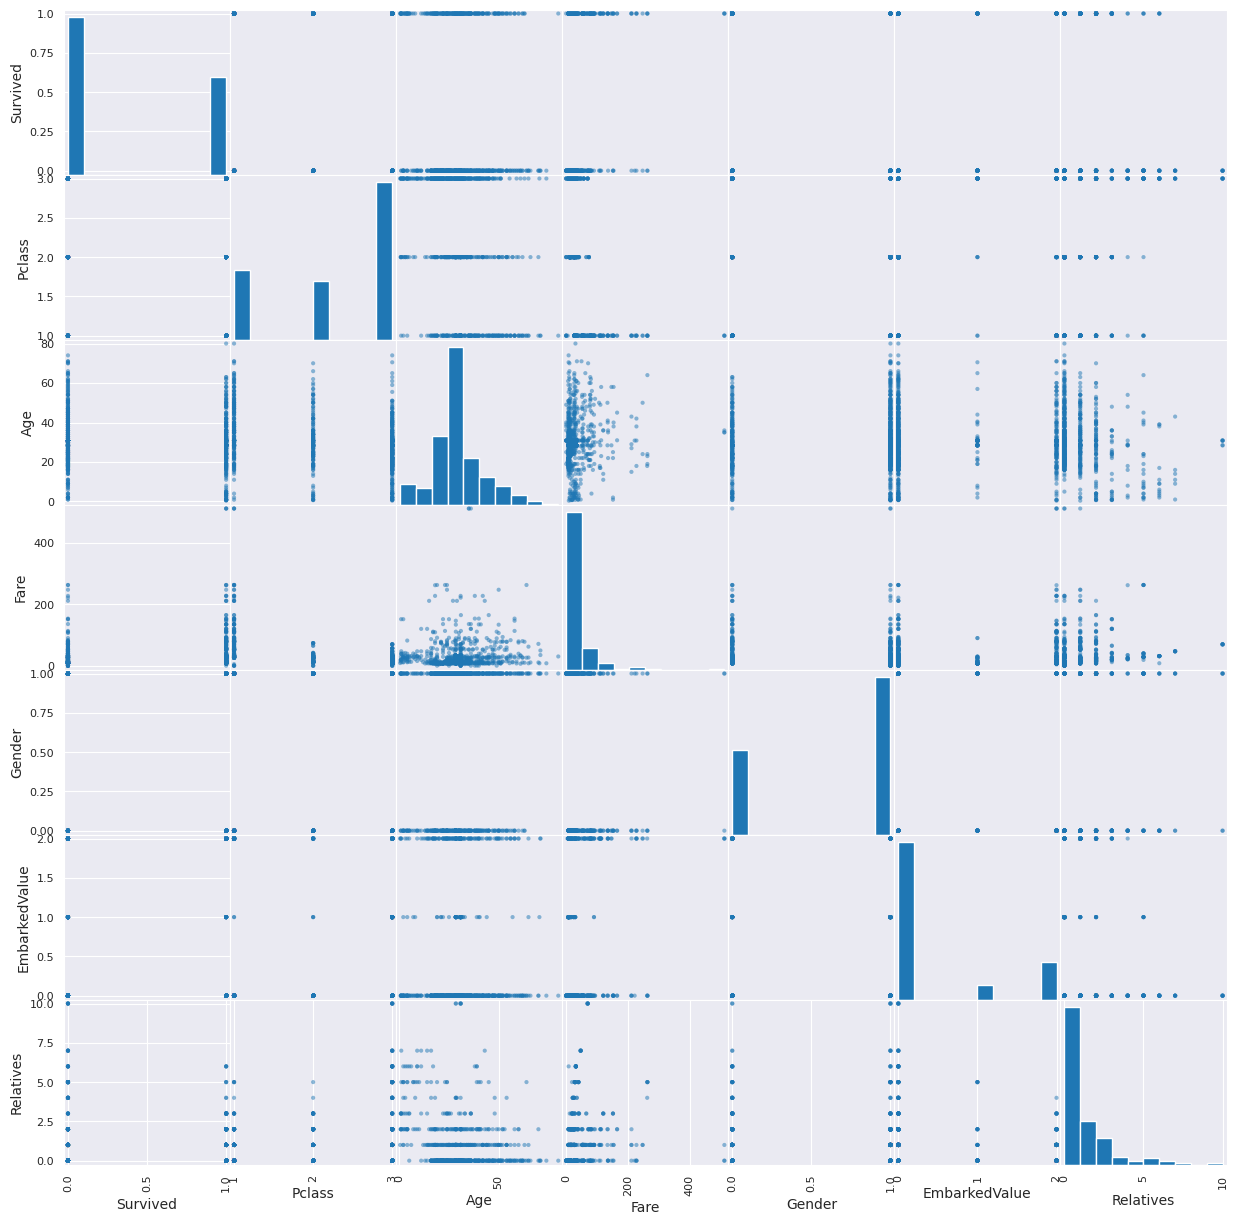

In [92]:
fig, axis = plt.subplots(figsize=(15, 15))
pd.plotting.scatter_matrix(df, ax=axis)

### Plot male-female Age statistic

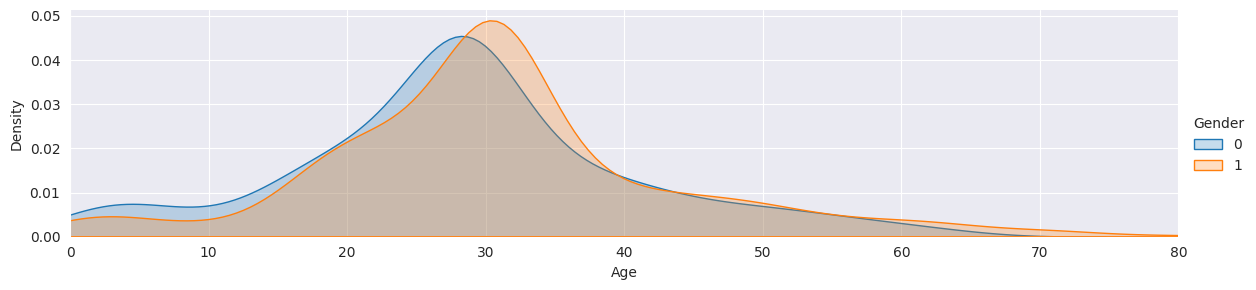

In [93]:
fig = sns.FacetGrid(df, hue='Gender', aspect=4)
fig.map(sns.kdeplot, 'Age', fill=True)
oldest = df['Age'].max()
fig.set(xlim=(0, oldest))
fig.add_legend()

### Plot male-female Count statistic

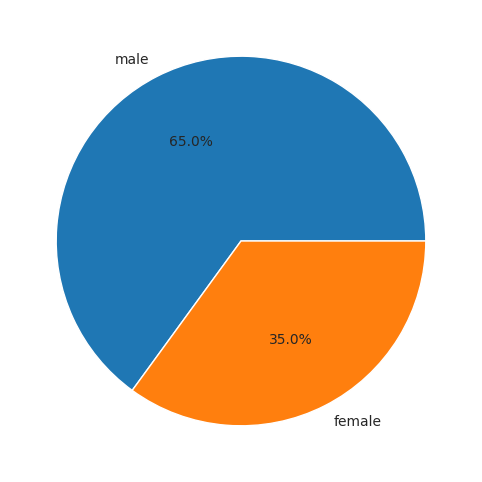

In [94]:
fig, axis = plt.subplots(figsize=(8, 6))
male_female_counts = df['Sex'].value_counts()
axis.pie(male_female_counts, labels=male_female_counts.index, autopct='%1.1f%%')


factors = df.columns.values.tolist()
factors = [f for f in factors if f not in ['Sex', 'Survived', 'Gender', 'Name', 'EmbarkedValue']]

### Plot male-female Survival Rate based on Age statistic

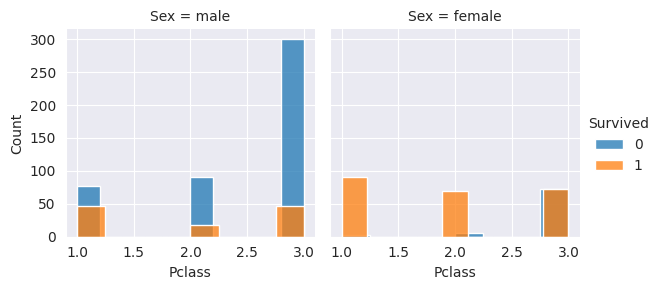

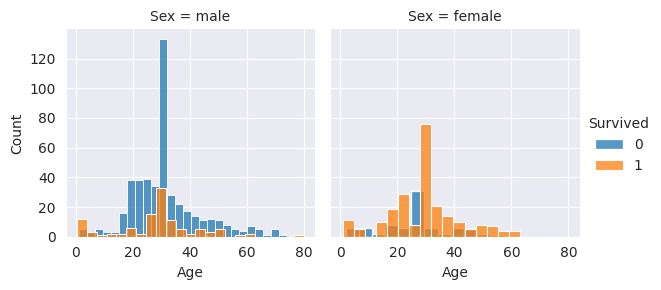

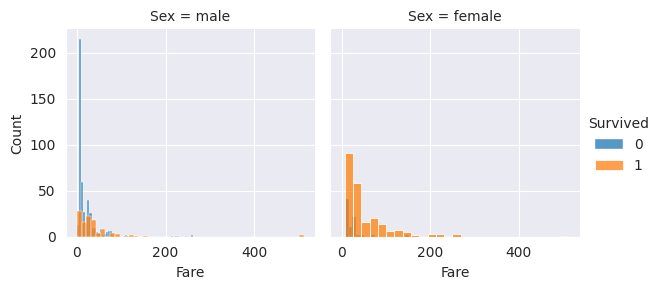

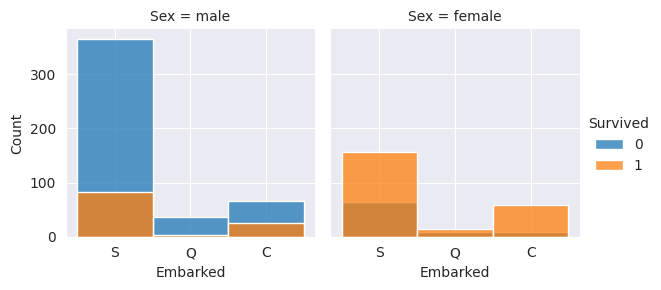

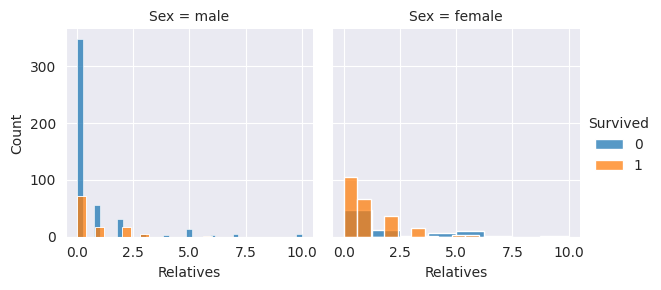

In [95]:
for row, factor in enumerate(factors):
    g = sns.FacetGrid(df[['Sex', 'Survived'] + [factor]], col='Sex', hue='Survived')
    g.map(sns.histplot, factor)
    g.add_legend()

### KMeans without PCA

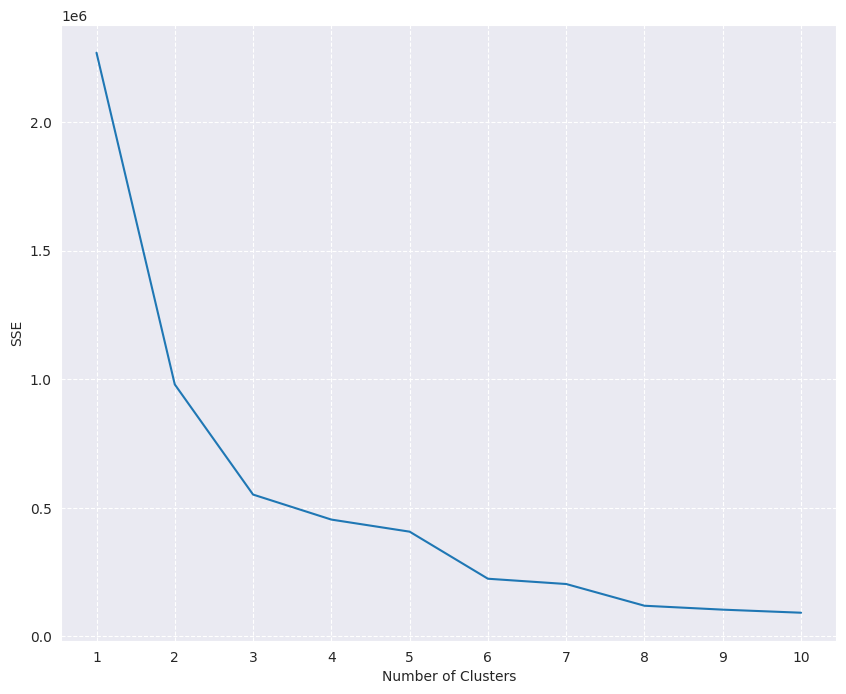

In [96]:
factors.remove('Embarked')
factors.append('EmbarkedValue')
kmeans_kwargs = {
    'init': 'random',
    'n_init': 10,
    'max_iter': 300,
    'random_state': 0,
}
sse = []
max_kernels = 10
features = df[['Survived'] + factors]
for k in range(1, max_kernels + 1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, max_kernels + 1), sse)
plt.xticks(range(1, max_kernels + 1))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.grid(linestyle='--')

### Elbow point

In [97]:
kl = KneeLocator(range(1, max_kernels + 1), sse, curve='convex', direction='decreasing')
kl.elbow

3

### Set number of clusters to elbow point

In [98]:
kmeans = KMeans(
    init='random',
    n_clusters=kl.elbow,
    n_init=10,
    max_iter=300,
    random_state=0
)
kmeans.fit(features)

KMeans(init='random', n_clusters=3, n_init=10, random_state=0)

In [99]:
kmeans.cluster_centers_

array([[  0.67391304,   1.23913043,  34.96908602,  83.96026449,
          1.41304348,   0.72463768],
       [  0.32152589,   2.54359673,  29.03663864,  16.70048021,
          0.72752044,   0.35286104],
       [  0.68421053,   1.        ,  31.66986452, 280.19978421,
          1.68421053,   1.15789474]])

In [100]:
fig = px.scatter_3d(
    df, x='Survived', y='Fare', z='Relatives',
    color=kmeans.labels_, hover_data=['Sex', 'Age', 'EmbarkedValue'],
    width=1000, height=800,
    title='Survived-Fare-Relatives KMeans Plot Clusters'
)
fig.update(layout_coloraxis_showscale=False)
fig.show()

### Agglomerate Clustering

In [101]:
model = AgglomerativeClustering(n_clusters=kl.elbow, affinity='euclidean', linkage='ward')
clust_labels = model.fit_predict(features)
agglomerative = pd.DataFrame(clust_labels)
agglomerative

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



,0
0,1
1,2
2,1
3,1
4,1
...,...
886,1
887,1
888,1
889,1


In [102]:
df.insert((df.shape[1]), 'agglomerative', agglomerative)
fig = px.scatter_3d(
    df, x='Survived', y='Fare', z='Relatives',
    color=df['agglomerative'], hover_data=['Sex', 'Age', 'EmbarkedValue'],
    width=1000, height=800,
    title='Survived-Fare-Relatives Agglomerative Plot Clusters'
)
fig.update(layout_coloraxis_showscale=False)
fig.show()

## Results

### Результати кластеризації показують невелику різницю у двох методах на даному наборі даних. Можливо, що інформації замало, тому не показується різниця

# Additional Assignment